# Timeseries of GPM precipitation accumulation co-located with Colorado Landslide events

## Author: Jacquelyn Witte

In [1]:
import os
from glob import glob

import earthpy as et
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

#### Change directory to where all the Capstone data reside

In [2]:
data_dir = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data')
os.chdir(data_dir)

#### Define the Global Landslide Catalog (GLC)

In [3]:
glc_file = os.path.join('capstone', 'landslide', 'nasa.glc.export.csv')
os.path.exists(glc_file) 

True

#### Read and subset to Colorado Landslides

In [4]:
# Read the GLC file
glc = pd.read_csv(glc_file)

glc_co = glc[(glc['country_code'] == 'US') & (
                                glc['admin_division_name'] == 'Colorado') & (
                                glc['landslide_trigger'] != 'freeze_thaw') &(
                            glc['landslide_trigger'] != 'snowfall_snowmelt')
            ]
# covert to datetime
glc_co['date'] = pd.to_datetime(glc_co['event_date'])
glc_co = glc_co.set_index('date').sort_index()
glc_co.head()

/var/folders/62/hcc5vcxn7rq_26dztbs26rfm000zzf/T/ipykernel_56290/2038222407.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glc_co['date'] = pd.to_datetime(glc_co['event_date'])


,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,...,country_code,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude
date,,,,,,,,,,,,,,,,,,,,,
2007-06-01,Sky-Hi News,http://www.skyhidailynews.com/news/13393638-11...,6253,6/1/07 0:00,NaN,Granby landfill,"All in all, the county has spent over $7 milli...",Granby landfill,5km,landslide,...,US,Colorado,1864.0,Granby,5.53226,10/17/14 19:11,11/20/17 15:17,2/15/18 15:51,-105.8752,40.0929
2007-08-14,Telluride Daily Planet,http://www.telluridegateway.com/articles/2007/...,185,8/14/07 0:00,NaN,"Tellride, CO, Hwy 145",Tues afternoon 4pm,"Tellride, CO, Hwy 145",10km,mudslide,...,US,Colorado,2475.0,Meeker,10.87949,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-107.8818,39.9425
2007-09-06,Craigdailypress.com,http://www.craigdailypress.com/news/2007/sep/0...,238,9/6/07 0:00,NaN,"River and Mt Warner Road, Steamboat Springs, CO","slide 75 feet down hill carrying trees, etc. o...","River and Mt Warner Road, Steamboat Springs, CO",1km,mudslide,...,US,Colorado,12088.0,Steamboat Springs,2.63588,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-106.8295,40.4613
2007-09-17,KJCT news,http://kjct8.com/Global/story.asp?S=7085534,268,9/17/07 0:00,NaN,"I-70 between New Castle and Silt, Colorado",mudslides and flooding on road in early and mi...,"I-70 between New Castle and Silt, Colorado",5km,mudslide,...,US,Colorado,4518.0,New Castle,4.25758,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-107.5798,39.5542
2008-04-13,vaildaily,http://www.vaildaily.com/article/20080428/NEWS...,499,4/13/08 0:00,NaN,U.S. Highway 6 between Kayak Crossing apartmen...,"A mudslide buried a lane, crushed a metal reta...",U.S. Highway 6 between Kayak Crossing apartmen...,5km,mudslide,...,US,Colorado,6447.0,Avon,3.03321,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-106.4879,39.6250


In [5]:
glc_co.columns

Index(['source_name', 'source_link', 'event_id', 'event_date', 'event_time',
       'event_title', 'event_description', 'location_description',
       'location_accuracy', 'landslide_category', 'landslide_trigger',
       'landslide_size', 'landslide_setting', 'fatality_count', 'injury_count',
       'storm_name', 'photo_link', 'notes', 'event_import_source',
       'event_import_id', 'country_name', 'country_code',
       'admin_division_name', 'admin_division_population',
       'gazeteer_closest_point', 'gazeteer_distance', 'submitted_date',
       'created_date', 'last_edited_date', 'longitude', 'latitude'],
      dtype='object')

#### Read the GPM data

In [6]:
gpm_nc = os.path.join('capstone', 'gpm', 'gpm_all_saved_on_disk.nc')
gpm_xr = xr.open_dataset(gpm_nc).squeeze()

In [7]:
gpm_xr

<xarray.Dataset>
Dimensions:                    (lon: 76, lat: 45, time: 3651, bnds: 2)
Coordinates:
  * lon                        (lon) float32 -109.3 -109.2 ... -101.9 -101.8
  * lat                        (lat) float32 36.85 36.95 37.05 ... 41.15 41.25
  * time                       (time) datetime64[ns] 2007-01-01 ... 2016-12-31
Dimensions without coordinates: bnds
Data variables:
    time_bnds                  (time, bnds) datetime64[ns] ...
    precipitationCal           (time, lon, lat) float32 ...
    precipitationCal_cnt       (time, lon, lat) int8 ...
    precipitationCal_cnt_cond  (time, lon, lat) int8 ...
    HQprecipitation            (time, lon, lat) float32 ...
    HQprecipitation_cnt        (time, lon, lat) int8 ...
    HQprecipitation_cnt_cond   (time, lon, lat) int8 ...
    randomError                (time, lon, lat) float32 ...
    randomError_cnt            (time, lon, lat) int8 ...
Attributes: (12/13)
    CDI:             Climate Data Interface version 1.9.8 (https://mpimet.mpg...
    Conventions:     CF-1.6
    BeginDate:       2007-01-01
    BeginTime:       00:00:00.000Z
    EndDate:         2007-01-01
    EndTime:         23:59:59.999Z
    ...              ...
    InputPointer:    3B-HHR-L.MS.MRG.3IMERG.20070101-S000000-E002959.0000.V06...
    title:           GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 d...
    DOI:             10.5067/GPM/IMERGDL/DAY/06
    ProductionTime:  2019-08-21T13:20:13.605Z
    history_L34RS:   'Created by L34RS v1.4.2 @ NASA GES DISC on April 18 202...
    CDO:             Climate Data Operators version 1.9.8 (https://mpimet.mpg...

#### Print the dimensions

In [17]:
gpm_xr.dims

Frozen({'lon': 76, 'lat': 45, 'time': 3651, 'bnds': 2})

#### Do a demo plot as a sanity check
- <u>NOTE</u> The actual dimensions are `[time, lon, lat]`
- The variable we want is named `precipitationCal`
    - long_name : Daily accumulated precipitation (combined microwave-IR) estimate
    - units : mm

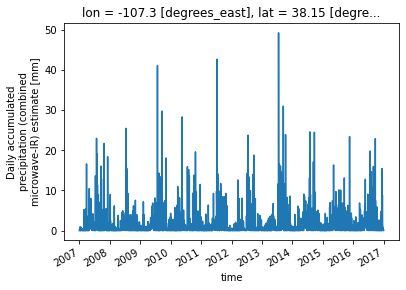

In [18]:
gpm_xr['precipitationCal'][:,20,13].plot()

#### Test the code to match a single co-located Landslide event using nearest neighbor method

In [19]:
test = gpm_xr['precipitationCal'].sel(indexers={'time':glc_co.index[0], 
                  'lon':glc_co.longitude[0],
                  'lat':glc_co.latitude[0]},
                method="nearest")
print(glc_co.index[0], glc_co.longitude[0], glc_co.latitude[0])
test

2007-06-01 00:00:00 -105.8752 40.0929


<xarray.DataArray 'precipitationCal' ()>
array(0.064783)
Coordinates:
    lon      float32 -105.8
    lat      float32 40.05
    time     datetime64[ns] 2007-06-01
Attributes:
    long_name:  Daily accumulated precipitation (combined microwave-IR) estimate
    units:      mm

#### Test that we know how to retrieve the precipitation time series going back 30 days

In [20]:
test = gpm_xr['precipitationCal'].sel(indexers={
                'time': pd.date_range(glc_co.index[0], periods=30, freq='-1D'),
                'lon': glc_co.longitude[0],
                'lat': glc_co.latitude[0]},
                method="nearest")
test

<xarray.DataArray 'precipitationCal' (time: 30)>
array([6.478293e-02, 6.615309e-01, 1.764799e-02, 5.893072e+00, 0.000000e+00,
       2.340568e-01, 2.230707e-01, 0.000000e+00, 4.846362e-01, 7.500689e-01,
       7.339960e-01, 1.206460e+00, 3.064084e-01, 0.000000e+00, 4.420716e-01,
       8.666319e-01, 5.000000e-03, 6.061469e-01, 1.982891e+00, 8.330569e-01,
       2.316850e-01, 6.033475e-02, 0.000000e+00, 2.945944e-01, 1.082624e-02,
       4.369069e-01, 2.509720e-01, 1.956400e+00, 2.135595e+00, 3.381911e-02],
      dtype=float32)
Coordinates:
    lon      float32 -105.8
    lat      float32 40.05
  * time     (time) datetime64[ns] 2007-06-01 2007-05-31 ... 2007-05-03
Attributes:
    long_name:  Daily accumulated precipitation (combined microwave-IR) estimate
    units:      mm

#### Plot the test

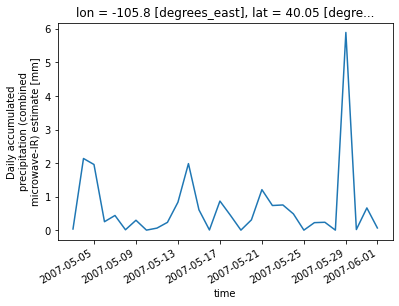

In [21]:
test.plot()

#### So far so good. Build a DataArray of these precipitation time series for all Colorado Landslides

In [22]:
gpm_date = []
gpm_id = []
gpm_ts = []
gpm_ts_list = []
for i, date in enumerate(glc_co.index):
    precip = gpm_xr['precipitationCal'].sel(indexers={
                'time': pd.date_range(date, periods=30, freq='-1D'),
                'lon': glc_co.longitude[i],
                'lat': glc_co.latitude[i]},
                method="nearest")
    gpm_ts_list.append(precip)
    gpm_ts_list[i]['landslideID'] = glc_co.event_id[i]
    
    
    # append the Landslide date
    # gpm_date.append(date)
    # append the landslide IS
    # gpm_id.append(glc_co.event_id[i])
    # append precipitation xarray timeseries
    # gpm_ts.append(precip)
    
gpm_ts_xr = xr.concat(gpm_ts_list, dim="landslideID")

In [31]:
for i, date in enumerate(glc_co.index):
    print(i, date, glc_co.event_id[i])

0 2007-06-01 00:00:00 6253
1 2007-08-14 00:00:00 185
2 2007-09-06 00:00:00 238
3 2007-09-17 00:00:00 268
4 2008-04-13 00:00:00 499
5 2008-05-28 00:00:00 555
6 2008-07-13 00:00:00 643
7 2008-07-22 00:00:00 658
8 2008-07-27 00:00:00 675
9 2008-08-06 00:00:00 690
10 2008-08-07 00:00:00 694
11 2008-08-23 00:00:00 742
12 2008-08-24 00:00:00 743
13 2009-04-20 23:25:00 1011
14 2010-06-28 19:00:00 2027
15 2010-07-23 14:30:00 2123
16 2010-07-26 15:45:00 2142
17 2010-07-27 15:00:00 2149
18 2010-07-31 18:46:00 2179
19 2010-08-01 02:30:00 2185
20 2010-08-19 15:00:00 2272
21 2010-08-19 15:00:00 2273
22 2010-08-19 15:00:00 2274
23 2010-08-19 15:00:00 2276
24 2010-08-19 15:00:00 2277
25 2010-08-19 15:00:00 2270
26 2010-08-19 15:00:00 2275
27 2010-08-19 15:40:00 2271
28 2011-06-05 00:00:00 3573
29 2011-06-27 06:00:00 3661
30 2011-07-04 00:00:00 3729
31 2011-07-07 00:00:00 3743
32 2011-07-12 18:00:00 3766
33 2011-07-12 18:00:00 3765
34 2011-07-13 18:00:00 3771
35 2011-07-14 00:00:00 3774
36 2011-07-18 

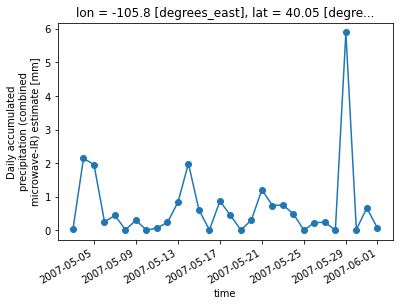

In [23]:
gpm_ts_xr[0].plot(marker='o')

#### Convert to a dataFrame for plotting/exporting

In [30]:
gpm_df = gpm_ts_xr.to_dataframe()

# Remove lat/lon columns
# gpm_df = gpm_df.drop(columns=['lon', 'lat'], axis=1)
# Reset
#gpm_df = gpm_df.reset_index().set_index('landslideID')

gpm_df[0:60]

lon        lat  precipitationCal
landslideID time                                               
6253        2007-05-03 -105.849998  40.049999          0.033819
            2007-05-04 -105.849998  40.049999          2.135595
            2007-05-05 -105.849998  40.049999          1.956400
            2007-05-06 -105.849998  40.049999          0.250972
            2007-05-07 -105.849998  40.049999          0.436907
            2007-05-08 -105.849998  40.049999          0.010826
            2007-05-09 -105.849998  40.049999          0.294594
            2007-05-10 -105.849998  40.049999          0.000000
            2007-05-11 -105.849998  40.049999          0.060335
            2007-05-12 -105.849998  40.049999          0.231685
            2007-05-13 -105.849998  40.049999          0.833057
            2007-05-14 -105.849998  40.049999          1.982891
            2007-05-15 -105.849998  40.049999          0.606147
            2007-05-16 -105.849998  40.049999          0.005000
            2007-05-17 -105.849998  40.049999          0.866632
            2007-05-18 -105.849998  40.049999          0.442072
            2007-05-19 -105.849998  40.049999          0.000000
            2007-05-20 -105.849998  40.049999          0.306408
            2007-05-21 -105.849998  40.049999          1.206460
            2007-05-22 -105.849998  40.049999          0.733996
            2007-05-23 -105.849998  40.049999          0.750069
            2007-05-24 -105.849998  40.049999          0.484636
            2007-05-25 -105.849998  40.049999          0.000000
            2007-05-26 -105.849998  40.049999          0.223071
            2007-05-27 -105.849998  40.049999          0.234057
            2007-05-28 -105.849998  40.049999          0.000000
            2007-05-29 -105.849998  40.049999          5.893072
            2007-05-30 -105.849998  40.049999          0.017648
            2007-05-31 -105.849998  40.049999          0.661531
            2007-06-01 -105.849998  40.049999          0.064783
            2007-07-16 -105.849998  40.049999               NaN
            2007-07-17 -105.849998  40.049999               NaN
            2007-07-18 -105.849998  40.049999               NaN
            2007-07-19 -105.849998  40.049999               NaN
            2007-07-20 -105.849998  40.049999               NaN
            2007-07-21 -105.849998  40.049999               NaN
            2007-07-22 -105.849998  40.049999               NaN
            2007-07-23 -105.849998  40.049999               NaN
            2007-07-24 -105.849998  40.049999               NaN
            2007-07-25 -105.849998  40.049999               NaN
            2007-07-26 -105.849998  40.049999               NaN
            2007-07-27 -105.849998  40.049999               NaN
            2007-07-28 -105.849998  40.049999               NaN
            2007-07-29 -105.849998  40.049999               NaN
            2007-07-30 -105.849998  40.049999               NaN
            2007-07-31 -105.849998  40.049999               NaN
            2007-08-01 -105.849998  40.049999               NaN
            2007-08-02 -105.849998  40.049999               NaN
            2007-08-03 -105.849998  40.049999               NaN
            2007-08-04 -105.849998  40.049999               NaN
            2007-08-05 -105.849998  40.049999               NaN
            2007-08-06 -105.849998  40.049999               NaN
            2007-08-07 -105.849998  40.049999               NaN
            2007-08-08 -105.849998  40.049999               NaN
            2007-08-09 -105.849998  40.049999               NaN
            2007-08-10 -105.849998  40.049999               NaN
            2007-08-11 -105.849998  40.049999               NaN
            2007-08-12 -105.849998  40.049999               NaN
            2007-08-13 -105.849998  40.049999               NaN
            2007-08-14 -105.849998  40.049999               NaN

#### Add a count of 30 days of precipitation measurements for each landslide event. This will help in plotting.

In [33]:
pd.set_option('display.max_rows', None)
print(len(gpm_df['precipitationCal'])/30)

cnts = []
for i in range(0, int(len(gpm_df['precipitationCal'])/30)): 
    cnts.extend(np.arange(30)+1)

gpm_df['days'] = cnts
gpm_df[0:100]

5642.0


lon        lat  precipitationCal  days
landslideID time                                                     
6253        2007-05-03 -105.849998  40.049999          0.033819     1
            2007-05-04 -105.849998  40.049999          2.135595     2
            2007-05-05 -105.849998  40.049999          1.956400     3
            2007-05-06 -105.849998  40.049999          0.250972     4
            2007-05-07 -105.849998  40.049999          0.436907     5
            2007-05-08 -105.849998  40.049999          0.010826     6
            2007-05-09 -105.849998  40.049999          0.294594     7
            2007-05-10 -105.849998  40.049999          0.000000     8
            2007-05-11 -105.849998  40.049999          0.060335     9
            2007-05-12 -105.849998  40.049999          0.231685    10
            2007-05-13 -105.849998  40.049999          0.833057    11
            2007-05-14 -105.849998  40.049999          1.982891    12
            2007-05-15 -105.849998  40.049999          0.606147    13
            2007-05-16 -105.849998  40.049999          0.005000    14
            2007-05-17 -105.849998  40.049999          0.866632    15
            2007-05-18 -105.849998  40.049999          0.442072    16
            2007-05-19 -105.849998  40.049999          0.000000    17
            2007-05-20 -105.849998  40.049999          0.306408    18
            2007-05-21 -105.849998  40.049999          1.206460    19
            2007-05-22 -105.849998  40.049999          0.733996    20
            2007-05-23 -105.849998  40.049999          0.750069    21
            2007-05-24 -105.849998  40.049999          0.484636    22
            2007-05-25 -105.849998  40.049999          0.000000    23
            2007-05-26 -105.849998  40.049999          0.223071    24
            2007-05-27 -105.849998  40.049999          0.234057    25
            2007-05-28 -105.849998  40.049999          0.000000    26
            2007-05-29 -105.849998  40.049999          5.893072    27
            2007-05-30 -105.849998  40.049999          0.017648    28
            2007-05-31 -105.849998  40.049999          0.661531    29
            2007-06-01 -105.849998  40.049999          0.064783    30
            2007-07-16 -105.849998  40.049999               NaN     1
            2007-07-17 -105.849998  40.049999               NaN     2
            2007-07-18 -105.849998  40.049999               NaN     3
            2007-07-19 -105.849998  40.049999               NaN     4
            2007-07-20 -105.849998  40.049999               NaN     5
            2007-07-21 -105.849998  40.049999               NaN     6
            2007-07-22 -105.849998  40.049999               NaN     7
            2007-07-23 -105.849998  40.049999               NaN     8
            2007-07-24 -105.849998  40.049999               NaN     9
            2007-07-25 -105.849998  40.049999               NaN    10
            2007-07-26 -105.849998  40.049999               NaN    11
            2007-07-27 -105.849998  40.049999               NaN    12
            2007-07-28 -105.849998  40.049999               NaN    13
            2007-07-29 -105.849998  40.049999               NaN    14
            2007-07-30 -105.849998  40.049999               NaN    15
            2007-07-31 -105.849998  40.049999               NaN    16
            2007-08-01 -105.849998  40.049999               NaN    17
            2007-08-02 -105.849998  40.049999               NaN    18
            2007-08-03 -105.849998  40.049999               NaN    19
            2007-08-04 -105.849998  40.049999               NaN    20
            2007-08-05 -105.849998  40.049999               NaN    21
            2007-08-06 -105.849998  40.049999               NaN    22
            2007-08-07 -105.849998  40.049999               NaN    23
            2007-08-08 -105.849998  40.049999               NaN    24
            2007-08-09 -105.849998  40.049999               NaN    25
            2007-08-10 -105.849998  40.04

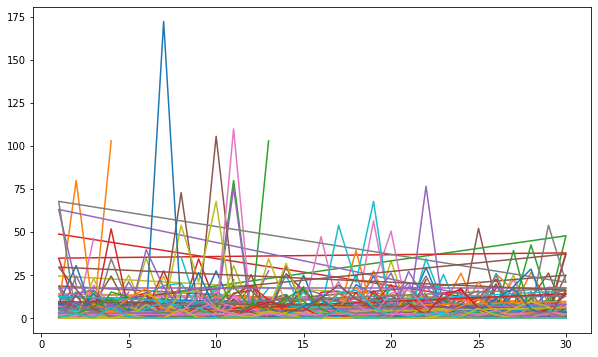

In [34]:
fig, ax = plt.subplots(figsize=(10, 6),sharex=True, sharey=True)

for id, df in gpm_df.groupby("landslideID"):
    ax.plot(df.days, df.precipitationCal)


In [ ]:
# I don't want to do this
# gpm_df.reset_index(level=1, drop=True)